In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Yogesh@8865",
                             database = "ecommerce"
                            )
cur = db.cursor()

# 1. List all unique cities where customers are located.

In [39]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [7]:
query = """ select count(order_id) from orders where year (order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 135303)

 # 3. Find the total sales per category.

In [13]:
query = """ 
    SELECT upper(products.product_category) category,
           ROUND(SUM(payments.payment_value), 2) sales
    FROM products 
    JOIN order_items 
        ON products.product_id = order_items.product_id
    JOIN payments 
        ON payments.order_id = order_items.order_id
    GROUP BY category
"""


cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category", "sales"])
df

,category,sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,BED TABLE BATH,13700429.37
4,AUTOMOTIVE,6818354.65
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


# 4 Calculate the percentage of orders that were paid in installments.

In [21]:
query = """ 
    select (sum(case when payment_installments >= 1 then 1
    else 0 end))/count(*) * 100 from payments
"""


cur.execute(query)

data = cur.fetchall()
"the percentage of orders that were paid in installments", data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

# 5 Count the number of customers from each state. 

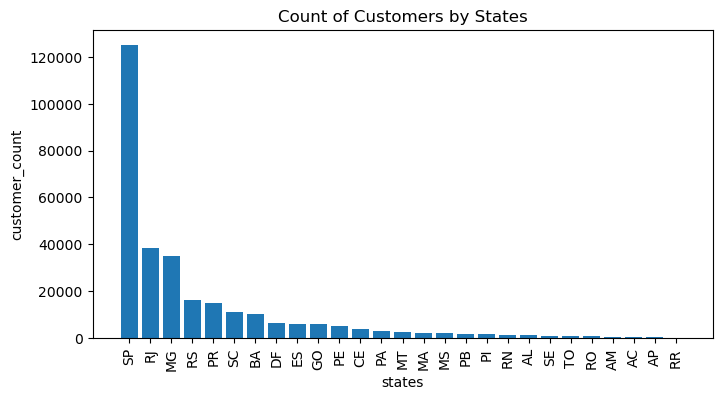

In [58]:
query = """ 
    select customer_state, count(customer_id)
    from customers
    group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)
plt.figure(figsize = (8, 4))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# 1. Calculate the number of orders per month in 2018.

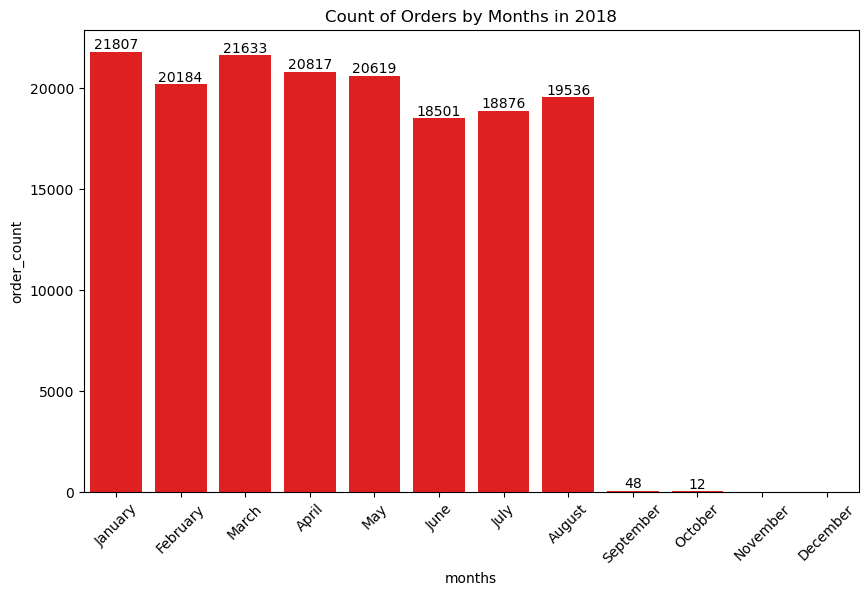

In [64]:
query = """ 
         select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.figure (figsize = (10, 6))
ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df,  order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [3]:
query = """ 
         WITH count_per_orders AS
(SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
FROM orders
JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, round(AVG(count_per_orders. oc), 2) avg_orders
FROM customers 
JOIN count_per_orders
ON customers.customer_id = count_per_orders.customer_id
GROUP BY customers.customer_city;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)

,0,1
0,treze tilias,7.64
1,indaial,6.69
2,sao jose dos campos,6.83
3,sao paulo,6.94
4,porto alegre,7.05
5,santos,6.97
6,sao francisco do sul,7.41
7,sao vicente,6.55
8,joinville,6.62
9,sao vendelino,6.00


# 3. Calculate the percentage of total revenue contributed by each product category.

In [5]:
query = """    SELECT upper(products.product_category) category,
ROUND((SUM(payments.payment_value)/ (SELECT SUM(payment_value) FROM payments)) * 100, 2)  sales_percentage
    FROM products 
    JOIN order_items 
        ON products.product_id = order_items.product_id
    JOIN payments 
        ON payments.order_id = order_items.order_id
    GROUP BY category
    ORDER BY sales_percentage  DESC;
    """
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Percentage distribution"])
df.head(5)

,Category,Percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71


# 4 Identify the correlation between product price and the number of times a product has been purchased.

In [6]:
query = """ SELECT products.product_category,
COUNT(order_items.product_id),
ROUND(AVG(order_items.price), 2)
FROM products
JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY products.product_category;
    """
cur.execute(query)

data = cur.fetchall()
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1, arr2])
print("the correlation between price and of times a product has been purchased is", a[0][1])

the correlation between price and of times a product has been purchased is -0.10631514167157562


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

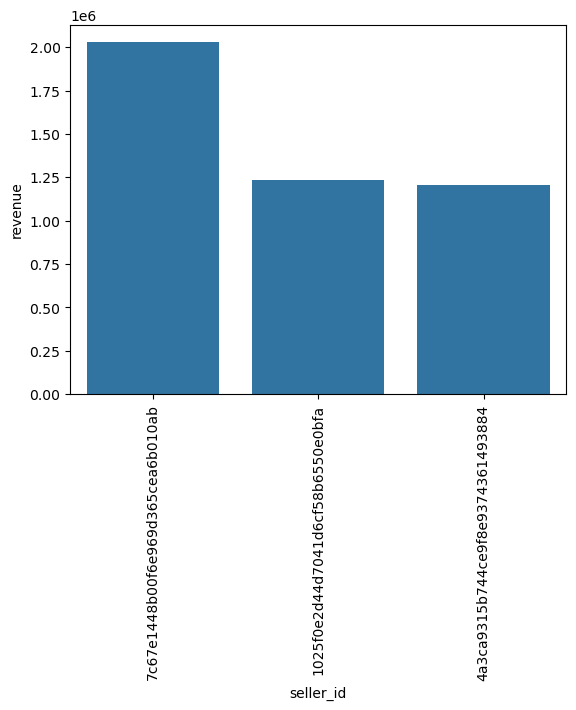

In [9]:
query = """ SELECT 
s.seller_id,
a.revenue,
DENSE_RANK () OVER (ORDER BY a.revenue DESC) AS rn
FROM(
	SELECT order_items.seller_id,
     SUM(payments.payment_value) as revenue
    FROM order_items
    JOIN payments
    ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id 
    ) AS a
    JOIN sellers s
    ON a.seller_id = s.seller_id;;
    """
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()


# 1. Calculate the moving average of order values for each customer over their order history.

In [36]:
query = """SELECT customer_id, order_purchase_timestamp, payment,
AVG(payment) OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp 
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
FROM 
(
  SELECT orders.customer_id, orders.order_purchase_timestamp,
  payments.payment_value AS payment
  FROM payments 
  JOIN orders ON payments.order_id = orders.order_id
) AS a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
623311,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
623312,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
623313,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
623314,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# 2. Calculate the cumulative sales per month for each year.

In [37]:
query = """SELECT years, months, payment, SUM(payment)
OVER(ORDER BY years, months) cumulative_sales FROM
(SELECT year(orders.order_purchase_timestamp)  AS years,
MONTH(orders.order_purchase_timestamp)AS months,
ROUND(SUM(payments.payment_value), 2) AS payment
FROM orders
JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years, months
ORDER BY years, months DESC) AS a;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,1513.44,1513.44
1,2016,10,354542.88,356056.32
2,2016,12,117.72,356174.04
3,2017,1,830928.24,1187102.28
4,2017,2,1751448.06,2938550.34
5,2017,3,2699181.60,5637731.94
6,2017,4,2506728.18,8144460.12
7,2017,5,3557512.92,11701973.04
8,2017,6,3067658.28,14769631.32
9,2017,7,3554297.52,18323928.84


# 3. Calculate the year-over-year growth rate of total sales.

In [48]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =  ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [51]:
query = """ with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;
"""
cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.

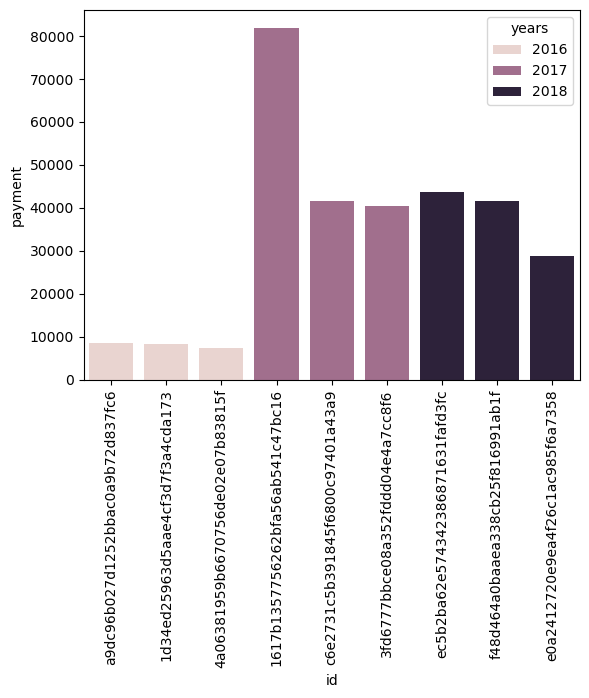

In [54]:
query = """ select years, customer_id, payments, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payments,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders
join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "id", "payment", "rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()